In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
from brisc.manuscript_analysis import barcodes_in_cells as bc_cells
from brisc.manuscript_analysis import match_to_library as match_lib
from brisc.manuscript_analysis import sensitivity as sens
from brisc.manuscript_analysis import mcherry_intensity as mcherry_int
from brisc.manuscript_analysis import distance_between_cells as dist_cells
from brisc.manuscript_analysis import spatial_plots_rabies as spatial

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

matplotlib.rcParams["pdf.fonttype"] = 42  # for pdfs

import flexiznam as flz

c:\Users\znamenp\AppData\Local\anaconda3\envs\brisc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Placeholder
# TODO: setup flexilims project
project = "barcode_diversity_analysis"
flexilims_session = flz.get_flexilims_session(project)
READ_ROOT = (
    flz.get_data_root("processed", flexilims_session=flexilims_session)
    / "rabies_manuscript_figures"
)
SAVE_ROOT = (
    flz.get_data_root("processed", flexilims_session=flexilims_session)
    / "rabies_manuscript_figures"
)
SAVE_ROOT.mkdir(parents=True, exist_ok=True)
reload = False

In [4]:
barseq_path=Path("Y:/")
main_path=Path("Z:/")

In [5]:
(
    in_situ_barcode_matches,
    random_barcode_matches,
    rv35_library,
) = match_lib.load_data(barseq_path=barseq_path, main_path=main_path)

good_cells, labeled_images, rabies_stack, spots_df = sens.load_data()

valid_mcherry = mcherry_int.load_mcherry_data()

(
    distances_same_bc,
    distances_diff_bc,
    nearest_diff_bc,
    adjacency_df,
    distances_same_bc_nonadj,
    distances_diff_bc_nonadj,
) = dist_cells.pairwise_barcode_distances_with_nearest_diff(
    data_path="becalia_rabies_barseq/BRAC8498.3e/chamber_07/"
)

cells_df = pd.read_pickle(
    barseq_path / "processed/becalia_rabies_barseq/BRAC8498.3e/analysis/cell_barcode_df.pkl"
)
cells_df = cells_df[cells_df["main_barcode"].notna()]
cells_df["n_unique_barcodes"] = cells_df["all_barcodes"].apply(len)
double_bc_data = bc_cells.load_double_barcode_data(
    data_path=barseq_path / "processed/becalia_rabies_barseq/BRAC8498.3e/analysis/"
)

  0%|          | 0/23 [00:00<?, ?it/s]C:\Users\znamenp\code\iss-preprocess\iss_preprocess\io\load.py:715: DeprecationWarning: Y:\processed\becalia_rabies_barseq\BRAC8780.3f\chamber_08\reg\tforms_best_hybridisation_round_1_1_1_0_0.npz not found. Loading from old path
  warnings.warn(
  4%|▍         | 1/23 [00:12<04:27, 12.14s/it]C:\Users\znamenp\code\iss-preprocess\iss_preprocess\io\load.py:715: DeprecationWarning: Y:\processed\becalia_rabies_barseq\BRAC8780.3f\chamber_08\reg\tforms_best_hybridisation_round_1_1_2_0_0.npz not found. Loading from old path
  warnings.warn(
  9%|▊         | 2/23 [00:23<04:03, 11.59s/it]C:\Users\znamenp\code\iss-preprocess\iss_preprocess\io\load.py:715: DeprecationWarning: Y:\processed\becalia_rabies_barseq\BRAC8780.3f\chamber_08\reg\tforms_best_hybridisation_round_1_1_3_0_0.npz not found. Loading from old path
  warnings.warn(
 13%|█▎        | 3/23 [00:34<03:48, 11.42s/it]C:\Users\znamenp\code\iss-preprocess\iss_preprocess\io\load.py:715: DeprecationWarning

Number of cells: 1489
Loaded 4122 mCherry cells position
Loaded 1954128 cells
Found 22766 barcoded cells
Found 563 unique starter barcodes in 575 starter cells
Found 442 barcodes present in only 1 starter cell


In [ ]:
import itertools
all_barcodes = list(set(itertools.chain.from_iterable(cells_df["all_barcodes"].values)))
barcodes_df = pd.DataFrame({"barcode": all_barcodes})
barcodes_df["n_starters"] = barcodes_df["barcode"].apply(
    lambda barcode: cells_df[cells_df["is_starter"] == True]["all_barcodes"].apply(
        lambda x: barcode in x
    ).sum()
)
barcodes_df["n_presynaptic"] = barcodes_df["barcode"].apply(
    lambda barcode: cells_df[cells_df["is_starter"] == False]["all_barcodes"].apply(
        lambda x: barcode in x
    ).sum()
)

Index(['random_sequences', 'min_edit_distance', 'lib_bc_sequence',
       'lib_bc_counts'],
      dtype='object')

Bin edges: [    0     5    10    15    20    25    30    35    40    45 10000]
Counts: [1076  301  109   73   34   27   17    6    6   40]
Counts: [163  94  66  38  39  34  23  14  11  81]
cells with <3 spots: 0.17528542646071188


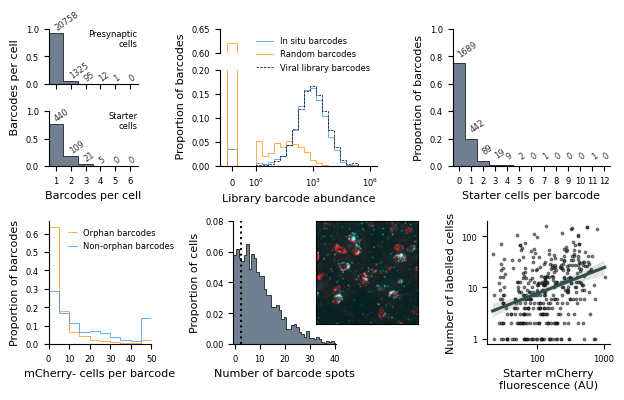

In [242]:
# Plot Fig.1
fontsize_dict = {"title": 8, "label": 8, "tick": 6, "legend": 6}
pad_dict = {"label": 1, "tick": 1, "legend": 5}
line_width = 0.5
line_alpha = 1

cm = 1 / 2.54
fig = plt.figure(figsize=(17.4 * cm, 17.4 * cm))
data_path = main_path / "home/shared/projects/barcode_diversity_analysis/collapsed_barcodes/"
save_path = main_path / "home/shared/presentations/becalick_2025"

save_fig = True
figname = "fig1_plasmid_barcoding_schema_library"

# Add blank squares with text
ax_bc_per_cell_presyn = fig.add_axes([0.08, 0.85, 0.13, 0.08])
bc_cells.plot_hist(
    cells_df[cells_df["is_starter"] == False],
    ax=ax_bc_per_cell_presyn,
    col="n_unique_barcodes",
    tick_fontsize=fontsize_dict["tick"],
    max_val=6,
)
ax_bc_per_cell_presyn.set_xticklabels([])
ax_bc_per_cell_presyn.text(6.5, 1, "Presynaptic\ncells", ha="right", va="top", fontsize=fontsize_dict["legend"])

ax_bc_per_cell_starter = fig.add_axes([0.08, 0.73, 0.13, 0.08])
bc_cells.plot_hist(
    cells_df[cells_df["is_starter"] == True],
    ax=ax_bc_per_cell_starter,
    col="n_unique_barcodes",
    tick_fontsize=fontsize_dict["tick"],
    max_val=6,
)
ax_bc_per_cell_starter.text(6.5, 1, "Starter\ncells", ha="right", va="top", fontsize=fontsize_dict["legend"])
plt.ylabel("         Barcodes per cell", loc="bottom", fontsize=fontsize_dict["label"])
plt.xlabel("Barcodes per cell", fontsize=fontsize_dict["label"])
ax_matches_to_lib = fig.add_axes([0.33, 0.73, 0.23, 0.14])
ax_matches_to_lib_top = fig.add_axes([0.33, 0.93-0.14/4, 0.23, 0.14/4])

match_lib.plot_matches_to_library(
    in_situ_barcode_matches,
    random_barcode_matches,
    rv35_library,
    ax=(ax_matches_to_lib, ax_matches_to_lib_top),
    label_fontsize=fontsize_dict["label"],
    tick_fontsize=fontsize_dict["tick"],
    line_width=line_width,
)


ax_starters_per_barcode = fig.add_axes([0.67, 0.73, 0.23, 0.20])
bc_cells.plot_hist(
    barcodes_df,
    col="n_starters",
    ax=ax_starters_per_barcode,
    tick_fontsize=fontsize_dict["tick"],
    show_zero=True,
)
plt.xlabel("Starter cells per barcode", fontsize=fontsize_dict["label"])
plt.ylabel("Proportion of barcodes", fontsize=fontsize_dict["label"])

ax_presyn_orphans = fig.add_axes([0.08, 0.47, 0.15, 0.18])
bc_cells.plot_presyn_per_barcode(
    barcodes_df,
    ax=ax_presyn_orphans,
    tick_fontsize=fontsize_dict["tick"],
    label_fontsize=fontsize_dict["label"],
)

ax_sensitivity_histo = fig.add_axes([0.35, 0.47, 0.15, 0.18])
bc_cells.plot_hist(
    good_cells,
    col="spot_count",
    ax=ax_sensitivity_histo,
    tick_fontsize=fontsize_dict["tick"],
    show_zero=True,
    show_counts=False,
    max_val=40,
)
ax_sensitivity_histo.set_xticks(np.arange(0, 50, 10))
ax_sensitivity_histo.set_ylim(0, 0.08)
plt.vlines(2.5, 0, 0.08, colors='k', linestyles='dotted')
print(f"cells with <3 spots: {good_cells['spot_count'].lt(3).mean()}")
plt.xlabel("Number of barcode spots", fontsize=fontsize_dict["label"])
plt.ylabel("Proportion of cells", fontsize=fontsize_dict["label"])

ax_spots_in_cells = fig.add_axes([0.47, 0.50, 0.15, 0.15])
sens.plot_cells_spots(
    good_cells,
    rabies_stack,
    labeled_images,
    ax=ax_spots_in_cells,
    roi_of_interest=6,
    min_y=1000,
    max_y=1600,
    min_x=1200,
    max_x=1800,
    vmaxs=[1500, 200],
)

ax_mcherry_fluor = fig.add_axes([0.72, 0.47, 0.18, 0.18])
im = mcherry_int.plot_mcherry_intensity_presyn(
    valid_mcherry,
    ax=ax_mcherry_fluor,
    label_fontsize=fontsize_dict["label"],
    tick_fontsize=fontsize_dict["tick"],
    marker_size=3,
)




# ax_dist_between_starters = fig.add_axes(ax_locations[8])
# im = dist_cells.plot_dist_between_starters(
#     distances_diff_bc_nonadj,
#     distances_same_bc_nonadj,
#     ax=ax_dist_between_starters,
#     bins=40,
#     max_dist=2,
#     label_fontsize=fontsize_dict["label"],
#     tick_fontsize=fontsize_dict["tick"],
#     line_width=line_width,
# )

# ax_dist_between_starters = fig.add_axes(ax_locations[9])
# spatial.plot_flat_ml_rv_cells(
#     cells_df,
#     ax=ax_dist_between_starters,
#     label_fontsize=7,
#     tick_fontsize=5,
#     presyn_size=1,
#     starter_size=2,
#     presyn_alpha=0.7,
#     legend_height=1.8,
# )

# ax_v1_rabies = fig.add_axes(ax_locations[10])
# ax_density = fig.add_axes(ax_locations[11])
# spatial.plot_rabies_cells(
#     ax_v1_rabies,
#     ax_density,
#     cells_df,
#     label_fontsize=fontsize_dict["label"],
#     tick_fontsize=fontsize_dict["tick"],
# )

# ax_stack = fig.add_axes(ax_locations[12])
# ax_violin = fig.add_axes(ax_locations[13])
# bc_cells.plot_double_barcode_barstack(
#     double_bc_data,
#     ax_stack,
#     ax_violin,
#     label_fontsize=fontsize_dict["label"],
#     tick_fontsize=fontsize_dict["tick"],
#     barcode_proportion=True,
#     swarmplot_dotsize=2,
# )


if save_fig:
    fig.savefig(save_path / f"{figname}.pdf", format="pdf")
    fig.savefig(save_path / f"{figname}.png", format="png")